<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Introduction to EarthDaily Analytics EarthMosaics
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #Sentinel-2

**Authors**: EarthDaily Analytics

**Last update:** 2024-12-11 (Created: 2024-12-02)

**References:**
- [EarthDaily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)

## Introduction
EarthDaily Analytics' EarthMosaics is the world's first fully automated service to create analysis-ready large area mosaics, combining both the Landsat and Sentinel-2 missions.

## Objectives
This document explores the basics of the EarthMosaic dataset, including:
* Key spatial and non-spatial properties
* How to retrieve mosaic pixel data using STAC
* Advanced diagnostics of mosaic metadata

First, import dependencies:

In [1]:
from earthdaily import EarthDataStore

In [2]:
import os
import requests
import rioxarray

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr

from datetime import datetime
from dotenv import load_dotenv

from odc.stac import stac_load

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

Next we load in environment variables, please update the associated [`template.env`](template.env) with credentials gathered from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [3]:
load_dotenv("template.env")

True

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

Connect to the Earth Data Store:

In [4]:
eds = EarthDataStore()

## EarthMosaic STAC Items

First, we will explore the properties shared by each EarthMosaic dataset.

Each image has a unique ID, which you can view on the [EarthPlatform](https://console.earthdaily.com/platform). We will start by inputting a sample mosaic over Rio Grande do Sul, Brazil:

In [5]:
item_id = "EDA_Mosaic_M_L2A_EM_Mosaic_8YNF2"

#### Setting Global Variables
* While this notebook looks at the Sample Collection, all full-resolution EarthMosaics will be in the `ai-ready-mosaics` Collection
* We will look at a subset of bands in the visible spectrum (`red`, `green`, `blue`) and the `data_source_map` band
* Output raster resolution and corresponding coordinate reference system

In [6]:
COLLECTION = "ai-ready-mosaics-sample"
BANDS = ['red', 'green', 'blue', 'data_source_map']
CRS = "epsg:3857"
RESOLUTION = 10.

Next, retrieve a STAC Item corresponding to the Mosaic through an EarthDataStore Search. Note the Item is simply a GeoJSON Feature:

In [7]:
items = eds.search(
    collections=COLLECTION,
    ids=[item_id],
)
item = items[0]
item

<Item id=EDA_Mosaic_M_L2A_EM_Mosaic_8YNF2>

A list of available assets, or bands, for each mosaic is included in the Item's `assets`:

In [8]:
for asset in item.assets:
    print(asset)

nir
red
blue
green
nir08
nir09
swir16
swir22
coastal
licence
rededge1
rededge2
rededge3
thumbnail
cloud_mask
work_order
data_source_map
data_source_metadata


#### *Note on Landsat 8/9 versus Sentinel-2 Mosaics*
EarthMosaics can be generated from imagery captured by [Landsat 8/9](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-9-operational-land-imager-and), [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2), or a haromization of both. While both platforms are spectrally similar, there are specific bands only present in Sentinel-2 not available in Landsat, such as the **nir09** and **red-edge** bands:

In [9]:
# Landsat Image assets
ls_items = eds.search(
    collections="ai-ready-mosaics-sample",
    ids=["EDA_Mosaic_M_L2A_EM_Mosaic_ZeiuG"],
)
ls_item = ls_items[0]
for asset in ls_item.assets:
    print(asset)

red
blue
green
nir08
swir16
swir22
coastal
licence
thumbnail
cloud_mask
work_order
data_source_map
data_source_metadata


Each Item also has a representative `geometry`:

In [10]:
item.geometry

{'type': 'Polygon',
 'coordinates': [[[-53.44996912333322, -29.066805892187226],
   [-53.44996912333322, -30.244736984602106],
   [-51.124606456600304, -30.244736984602106],
   [-51.124606456600304, -29.066805892187226],
   [-53.44996912333322, -29.066805892187226]]]}

and `bounding box`:

In [11]:
item.bbox

[-53.4499691233332, -30.2447369846021, -51.1246064566003, -29.0668058921872]

Several convenient properties are also available, including:
* **Resolution** (`gsd`, _float_)
* **Source Image Platforms** (`platform`, _list_)
* **Start Date** (`start_datetime`, _string_)
* **End Date** (`end_datetime`, _string_)

In [12]:
props = item.properties
print(f"Resolution: {props['gsd']}")
print(f"Source Image Platforms: {props['platform']}")
print(f"Mosaic Start Date: {props['start_datetime']}")
print(f"Mosaic End Date: {props['end_datetime']}")

Resolution: 10.0
Source Image Platforms: sentinel-2a,sentinel-2b
Mosaic Start Date: 2024-02-21T13:40:29.936000Z
Mosaic End Date: 2024-04-21T13:40:56.638000Z


## Loading Mosaics as Raster Data
Next up we explore the basics of retrieving a mosaic's raster data, typically through `stac_load`. This returns an `xarray Dataset` object:

In [13]:
dataset = stac_load(
    [item],
    bands=BANDS,
    crs=CRS, 
    resolution=RESOLUTION,
    ## Loading in subset of full Mosaic to limit processing times
    bbox=[-52.38175462, -29.85496458, -52.07547469, -29.61356083]
)
dataset

<xarray.Dataset> Size: 169MB
Dimensions:          (y: 3096, x: 3411, time: 1)
Coordinates:
  * y                (y) float64 25kB -3.454e+06 -3.454e+06 ... -3.485e+06
  * x                (x) float64 27kB -5.831e+06 -5.831e+06 ... -5.797e+06
    spatial_ref      int32 4B 3857
  * time             (time) datetime64[ns] 8B 2024-02-21T13:40:29.936000
Data variables:
    red              (time, y, x) float32 42MB 1.216e+03 1.201e+03 ... 1.104e+03
    green            (time, y, x) float32 42MB 1.388e+03 1.365e+03 ... 1.161e+03
    blue             (time, y, x) float32 42MB 1.13e+03 1.118e+03 ... 1.059e+03
    data_source_map  (time, y, x) float32 42MB 11.0 11.0 11.0 ... 36.0 36.0 36.0

Here we'll plot an RGB True Color Composite (TCC):

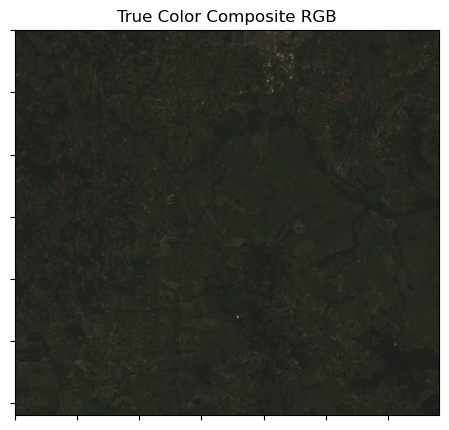

In [14]:
rgb_ds = dataset.isel(time=0)
rgb_arr = np.stack(
    [rgb_ds['red'], rgb_ds['green'], rgb_ds['blue']],
    axis=-1
)
fig, ax = plt.subplots(figsize=(10,5))
# Digital Number (DN) values typically range from 0-10000
ax.imshow(((rgb_arr/10000)*255).astype('uint8'))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("True Color Composite RGB")
plt.show()

## Features Specific to EarthMosaic Datasets

### Mosaic Source Metadata
In order to determine which date, or more specifically which Sentinel-2 and/or Landsat 8/9 source image, a particular pixel is derived from, we can assess properties contained within the mosaic datset. 

First, we will retrieve the `data_source_map` band:

In [15]:
dmap = dataset['data_source_map'].values
unique_indices = np.unique(dmap)
unique_indices

array([ 9., 10., 11., 13., 14., 34., 36., 37., 38., 39., 40., 42.],
      dtype=float32)

Each value in the `data_source_map` band corresponds to a lookup table contained in the `data_source_metadata` dictionary. Here, we retrieve that dictionary through a simple `requests` call:

In [16]:
meta = item.assets['data_source_metadata'].to_dict()
meta = requests.get(meta['alternate']['download']['href']).json()
meta['1']

{'dataset': 'S2B_22JDN_20240327_0_L2A',
 'source': [{'rel': 'canonical',
   'href': 's3://sentinel-cogs/sentinel-s2-l2a-cogs/22/J/DN/2024/3/S2B_22JDN_20240327_0_L2A/S2B_22JDN_20240327_0_L2A.json',
   'type': 'application/json'},
  {'rel': 'license',
   'href': 'https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice'},
  {'rel': 'derived_from',
   'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l1c/items/S2B_22JDN_20240327_0_L1C',
   'type': 'application/geo+json'},
  {'rel': 'self',
   'href': 'https://edc-skyfox.eds.earthdaily.com/archive/v1/stac/v1/collections/sentinel-2-l2a/items/S2B_22JDN_20240327_0_L2A',
   'type': 'application/geo+json'},
  {'rel': 'parent',
   'href': 'https://edc-skyfox.eds.earthdaily.com/archive/v1/stac/v1/collections/sentinel-2-l2a',
   'type': 'application/json'},
  {'rel': 'collection',
   'href': 'https://edc-skyfox.eds.earthdaily.com/archive/v1/stac/v1/collections/sentinel-2-l2a',
   'type': 'application/json

Next, we can retrieve the corresponding `href` for each value in order to visualize source Sentinel-2 Image IDs:

In [17]:
date_map = []
for i, info in meta.items():
    source_s2_ds = info['dataset']
    date = source_s2_ds.split('_')[-3]
    date_map.append({
        'value':int(i),
        'date':date, 
        'source_s2_id':source_s2_ds
    })
date_df = pd.DataFrame(date_map)
date_df['date']=pd.to_datetime(date_df['date'])
date_df.head(5)

,value,date,source_s2_id
0,0,2024-04-06,S2B_22JDN_20240406_0_L2A
1,1,2024-03-27,S2B_22JDN_20240327_0_L2A
2,2,2024-03-24,S2B_22JDN_20240324_0_L2A
3,3,2024-03-07,S2B_22JDN_20240307_0_L2A
4,4,2024-04-06,S2B_22JDM_20240406_0_L2A


Last, we can plot the corresponding Sentinel-2 collection IDs on the pixel-level:

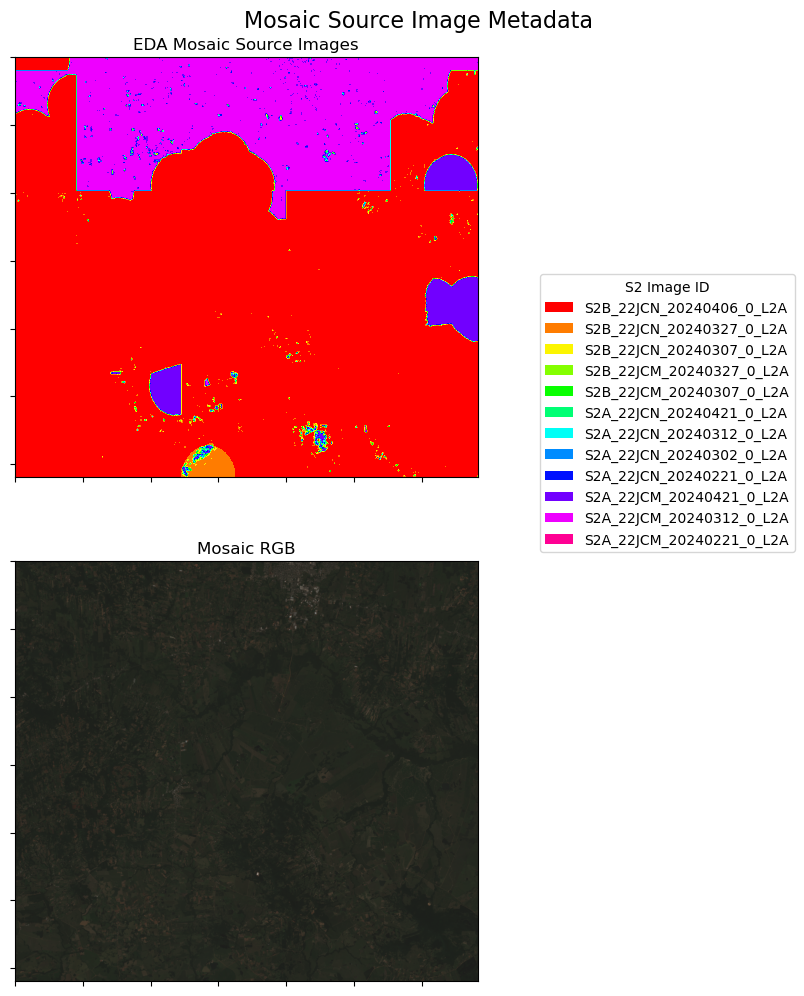

In [18]:
fig, ax = plt.subplots(
    figsize=(6,12), 
    nrows=2, 
    ncols=1
)
plt.suptitle("Mosaic Source Image Metadata", fontsize=16, x=0.8, y=0.92)
ax[1].imshow(((rgb_arr/10000)*255).astype('uint8'))
ax[1].set_title("Mosaic RGB")

n_categories = len(unique_indices)
colors = np.zeros((n_categories, 3))
for i in range(n_categories):
    hue = i/n_categories
    colors[i] = plt.cm.hsv(hue)[:3]
cmap = ListedColormap(colors)

im = ax[0].imshow(dmap[0], cmap=cmap)
ax[0].set_title("EDA Mosaic Source Images")

legend_elements = []
for i, idx in enumerate(unique_indices):
    idx_df = date_df[date_df['value'] == idx]
    source_s2_id = idx_df['source_s2_id'].iloc[0]
    legend_elements.append(
        Patch(
            facecolor=colors[i], 
            label=source_s2_id
            )
    )

ax[0].legend(
    handles=legend_elements,
    bbox_to_anchor=(1.7, 0.5), 
    title='S2 Image ID'
)

ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

plt.savefig("mosaics_s2_data_source.png")
plt.show()

#### More on Temporal Diagnostics of EarthMosaics
Beyond just looking at source Sentinel-2 image IDs, we can determine which date a particular came from with this metadata. 

In [19]:
## Filter values not present within our bounding box
date_df = date_df[date_df['value'].isin(unique_indices)]
dates = pd.to_datetime(date_df['date'].dt.strftime('%Y-%m-%d'))
unique_dates = sorted(list(set(dates)))

Here we will set a dictionary lookup table to cast numpy array values to int corresponding to it's acquisition date:

In [20]:
# Map of date: value
date_mapping = {i: date for i, date in zip(range(len(date_df)), date_df['date'])}
date_to_num = {date: i for i, date in enumerate(unique_dates)}
value_to_datenum = {int(val): date_to_num[date] for val, date in zip(date_df['value'], dates)}

Replace source_map value with date it is associated with

In [21]:
temporal_data = np.vectorize(lambda x: value_to_datenum.get(int(x), np.nan))(dmap[0])
np.unique(temporal_data)

array([0, 1, 2, 3, 4, 5, 6])

##### Plotting Acquisition Dates

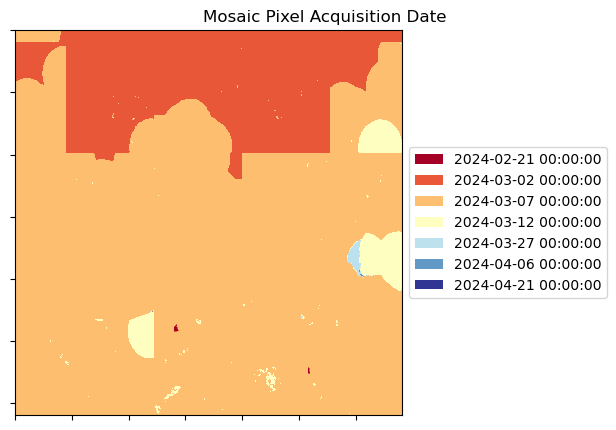

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(unique_dates)))
cmap = ListedColormap(colors)
im = ax.imshow(temporal_data, aspect='auto', cmap=cmap)
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i]) for i in range(len(unique_dates))]
ax.legend(legend_elements, unique_dates, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("Mosaic Pixel Acquisition Date", x=0.8)
plt.show()

##### Summarize Pixel Count by Acquisition Date

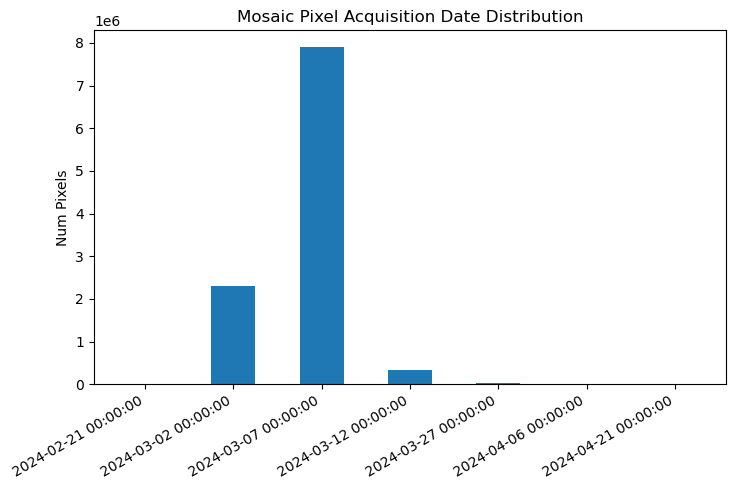

In [23]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax.hist(
    temporal_data.flatten(), 
    bins=np.arange(len(unique_dates) + 1) - 0.5,
    align='mid', 
    rwidth=0.5
    )
ax.set_xticks(range(len(unique_dates)))
ax.set_xticklabels(
    unique_dates,
    rotation=30, 
    ha='right'
)
plt.title("Mosaic Pixel Acquisition Date Distribution")
ax.set_ylabel("Num Pixels")
plt.tight_layout()
plt.show()

### _Cleaning Up_

In [24]:
os.remove("mosaics_s2_data_source.png")